In [140]:
! pip install --quiet tables
! pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [141]:
#imports
import numpy as np
import pandas as pd
import h5py
import hdf5plugin

import os, gc, scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from colorama import Fore, Back, Style
from sklearn.decomposition import TruncatedSVD
from matplotlib.ticker import PercentFormatter

# Loading files & arranging data

In [142]:
df_metadata = pd.read_csv("metadata/metadata.csv")
df_metadata_d2 = pd.read_csv("metadata/metadata_cite_day_2_donor_27678.csv")
print(df_metadata.shape)
print(df_metadata_d2.shape)
print(df_metadata.head())

(281528, 5)
(7016, 5)
        cell_id  day  donor cell_type technology
0  c2150f55becb    2  27678       HSC    citeseq
1  65b7edf8a4da    2  27678       HSC    citeseq
2  c1b26cb1057b    2  27678      EryP    citeseq
3  917168fa6f83    2  27678      NeuP    citeseq
4  2b29feeca86d    2  27678      EryP    citeseq


# Obtaining subset of data

-   note:  donors 13176, 31800, and 32606 (train), 27678 (test)
-   day 2,3,4 in train set, day 7 test set
-   index for new df_cite_input and df_cite_target is set as the cell id
    -    index is set to save as the first column in the csv
    -    pd.read_csv(r"subset/train_cite_inputs.csv", **index_col=0**) to load the df with first column as index

In [143]:
# obtaining metadata for training data
df_meta_citeseq = df_metadata.loc[df_metadata.technology=="citeseq"]
df_meta_citeseq.shape

(119651, 5)

In [187]:
# training subset: obtaining subset of size n per day per sample
x = list([13176,31800,32606]) # note:  donors 13176, 31800, and 32606 (train), 27678 (test)
y = list([2,3,4]) # day 2,3,4 in train set, day 7 test set
df_meta_citeseq_subset = pd.DataFrame(columns=df_meta_citeseq.columns)

for donor in x:
    for day in y:
        df = df_meta_citeseq.loc[(df_meta_citeseq.donor == donor) & (df_meta_citeseq.day == day)]
        df = df.iloc[:1000, :]
        df_meta_citeseq_subset = pd.concat([df_meta_citeseq_subset, df], axis=0, ignore_index=True)
        
    

-   pd.read_hdf can access the file, but takes alot of time since it loads the entire data into the dataframe

In [163]:
# testing = pd.read_hdf("data/train_cite_targets.h5")
# testing.shape

(70988, 140)

using h5py.file ... 

In [189]:
f = h5py.File("data/train_cite_inputs.h5",'r')
print(f['train_cite_inputs']['axis0'].shape)            # (22050,)
print(f['train_cite_inputs']['axis1'].shape)            # (70988,)
print(f['train_cite_inputs']['block0_items'].shape)     # (22050,)
print(f['train_cite_inputs']['block0_values'].shape)    # (70988, 22050)

(22050,)
(70988,)
(22050,)
(70988, 22050)


In [165]:
f['train_cite_inputs']['axis0']

<HDF5 dataset "axis0": shape (22050,), type "|S41">

converting datatype : numpy bytes in the h5 files into strings for gene names
-   str_gene_id : gene id + names
-   list_genes_names, list_genes_ids

In [190]:
gene_id = f['train_cite_inputs']['axis0'][:]
type(gene_id[1]) # numpy bytes
str_gene_id = [gene_id[i].decode('UTF-8') for i in range(22050)]

list_genes_names = [t.split('_')[1] for t in str_gene_id ]
list_genes_ids = [t.split('_')[0] for t in str_gene_id ]

cell_id = f['train_cite_inputs']['axis1'][:]
str_cell_id = [cell_id[i].decode('UTF-8') for i in range(70988)]


In [191]:
index = [str_cell_id.index(id) for id in df_meta_citeseq_subset.cell_id]
index.sort() # array can only be accessed with ordered index
x = f['train_cite_inputs']['block0_values'][index]
x.shape

new_cell_order = [str_cell_id[i] for i in index] # retrieving the current order of cell id in df
df_cite_input = pd.DataFrame(x, columns=str_gene_id, index=new_cell_order)

# writing to csv takes pretty long
df_cite_input.to_csv("subset/train_cite_inputs.csv")

In [192]:
# updating metadata with the same cell id order as the subset df
df_meta_citeseq_subset = df_meta_citeseq_subset.set_index('cell_id')
df_meta_citeseq_subset = df_meta_citeseq_subset.reindex(new_cell_order)  
df_meta_citeseq_subset.to_csv("subset/metadata_subset.csv")

In [193]:
df_cite_input

,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3e6e6c29d6ac,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.525487,0.0,0.0,0.000000,4.525487,0.000000,0.0
9936f9296fee,0.0,0.0,0.0,0.0,0.0,0.000000,4.754463,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
bca8efa0d09d,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.898782,0.0
d0f09af9fff0,0.0,0.0,0.0,0.0,0.0,0.000000,4.082303,4.766980,0.000000,0.0,...,4.082303,0.000000,4.082303,0.000000,0.0,0.0,4.082303,4.766980,0.000000,0.0


In [194]:
f.close()

f = h5py.File("data/train_cite_targets.h5",'r')
print(f['train_cite_targets']['axis0'].shape)            # (140,)
print(f['train_cite_targets']['axis1'].shape)            # (70988,)
print(f['train_cite_targets']['block0_items'].shape)     # (140,)
print(f['train_cite_targets']['block0_values'].shape)    # (70988, 140)

(140,)
(70988,)
(140,)
(70988, 140)


In [195]:
protein_id = f['train_cite_targets']['axis0'][:]
type(protein_id[1]) # numpy bytes
str_protein_id = [protein_id[i].decode('UTF-8') for i in range(140)]

cell_id_1 = f['train_cite_targets']['axis1'][:]
str_cell_id_1 = [cell_id[i].decode('UTF-8') for i in range(70988)]

In [196]:
# same index/ cell order is used to retrieve corr rows
x = f['train_cite_targets']['block0_values'][index]
x.shape # (450,140)

df_cite_target = pd.DataFrame(x, columns=str_protein_id, index=new_cell_order)

df_cite_target.to_csv("subset/train_cite_targets.csv")
f.close()

df_cite_target

,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3e6e6c29d6ac,-0.188832,-0.412852,-0.893595,5.470314,4.070098,3.402995,-0.586871,1.270303,0.484487,-0.112730,...,-1.714715,4.516867,-0.093296,-0.968569,-0.088244,-0.071577,2.852950,0.098138,0.163113,-0.074378
9936f9296fee,-0.246010,-0.048309,0.850810,2.963092,5.363526,8.094519,0.883258,0.154297,0.399742,1.023055,...,1.972329,8.132099,0.930745,0.481112,-0.123342,0.225815,6.332715,0.020397,3.940991,2.457720
bca8efa0d09d,-0.173212,0.060921,0.137368,5.829977,5.791604,10.650406,3.459610,-1.020310,0.329388,3.022492,...,-0.177167,8.867304,2.005281,-0.580970,-0.078655,-0.050644,5.314260,0.980635,1.798774,3.910896
d0f09af9fff0,-0.501653,-0.431886,-0.066127,1.617914,4.148017,3.951902,-0.586147,-0.110303,1.209268,0.177049,...,0.290977,1.864020,-0.600181,0.261019,-0.280268,0.231431,7.089459,0.534072,4.512008,5.365750


## Checking metadata for donor 27678
-   note:  donors 13176, 31800, and 32606 (train), 27678 (test)
-   first 7476 rows of test (day 2, donor 27678) are identical to the first 7476 rows of train (day 2, donor 32606)

updates: test results for donor 27678 will be ignored
-   however, the metadata and test inputs are provided
-   but the new metadata is not found/different from the old metadata file


In [32]:
df_metadata.cell_id[:7476]
donor2_old = df_metadata.loc[(df_metadata.donor == 27678) & (df_metadata.technology=="citeseq")& (df_metadata.day==2)]
donor32606 = df_metadata.loc[(df_metadata["donor"] == 32606) & (df_metadata.technology=="citeseq")& (df_metadata.day==2)]
print(donor2_old.shape)
print(donor32606.shape)

(7476, 5)
(7476, 5)


In [33]:
match = donor2_old.merge(df_metadata_d2, how='inner',on='cell_id')
print("Equivalent obersvations in new metadata and old metadata is:",match.shape[0])

Equivalent obersvations in new metadata and old metadata is: 0


# Arranging data

50 cells per day, per donor = 450 cells
df_meta_citeseq
df_meta_citeseq_subset
df_cite_input
df_cite_target

3) Some targets are NOT CD**: 'HLA-A-B-C', 'TIGIT', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b',
   'Rat-IgG2b', 'Podoplanin', 'IgM', 'KLRG1', 'HLA-DR', 'CX3CR1',
   'integrinB7', 'TCR', 'Rat-IgG1', 'Rat-IgG2a', 'FceRIa', 'IgD',
   'TCRVa7.2', 'TCRVd2', 'LOX-1', 'HLA-E'

weird = : 'Rat-IgG1', 'Rat-IgG2a', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b',

https://www.kaggle.com/code/alexandervc/mmscel-eda-targets-citeseq-02#What-is-about-? 

In [173]:
df_meta_citeseq_subset = pd.read_csv(r"subset/metadata_subset.csv")
df_cite_input = pd.read_csv(r"subset/train_cite_inputs.csv", index_col=0) 
df_cite_target = pd.read_csv(r"subset/train_cite_targets.csv", index_col=0)

In [174]:
df_meta_citeseq_subset

,cell_id,day,donor,cell_type,technology
0,45006fe3e4c8,2,32606,HSC,citeseq
1,d02759a80ba2,2,32606,HSC,citeseq
2,c016c6b0efa5,2,32606,EryP,citeseq
3,ba7f733a4f75,2,32606,NeuP,citeseq
4,fbcf2443ffb2,2,32606,EryP,citeseq
...,...,...,...,...,...
895,cd508c4b9059,4,31800,EryP,citeseq
896,e354c99fa9e2,4,31800,EryP,citeseq
897,b878151a736f,4,31800,EryP,citeseq
898,8b5750d89113,4,31800,HSC,citeseq


['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44', 'CD14', 'CD16', 'CD25', 'CD45RO', 'CD279', 'TIGIT', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'CD20', 'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5', 'CD195', 'CD32', 'CD196', 'CD185', 'CD103', 'CD69', 'CD62L', 'CD161', 'CD152', 'CD223', 'KLRG1', 'CD27', 'CD107a', 'CD95', 'CD134', 'HLA-DR', 'CD1c', 'CD11b', 'CD64', 'CD141', 'CD1d', 'CD314', 'CD35', 'CD57', 'CD272', 'CD278', 'CD58', 'CD39', 'CX3CR1', 'CD24', 'CD21', 'CD11a', 'CD79b', 'CD244', 'CD169', 'integrinB7', 'CD268', 'CD42b', 'CD54', 'CD62P', 'CD119', 'TCR', 'Rat-IgG1', 'Rat-IgG2a', 'CD192', 'CD122', 'FceRIa', 'CD41', 'CD137', 'CD163', 'CD83', 'CD124', 'CD13', 'CD2', 'CD226', 'CD29', 'CD303', 'CD49b', 'CD81', 'IgD', 'CD18', 'CD28', 'CD38', 'CD127', 'CD45', 'CD22', 'CD71', 'CD26', 'CD115', 'CD63', 'C

array([[<AxesSubplot: title={'center': 'count'}>]], dtype=object)

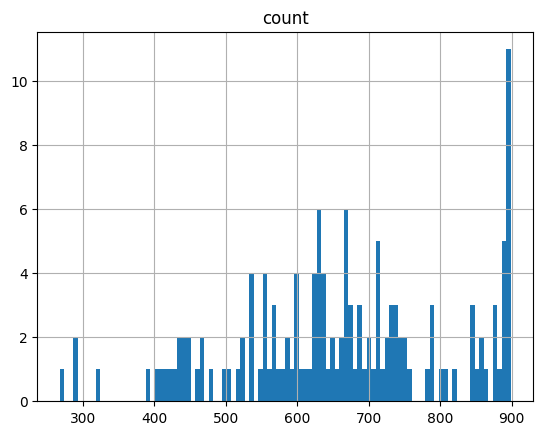

In [175]:
# 500 cells
cols = (df_cite_target > 0).sum(axis=0)
row = list(cols.index)
print(row)
cols = pd.DataFrame(cols[:],index=cols.index, columns=['count'])
# print(cols)
cols.hist(bins=100)

<AxesSubplot: >

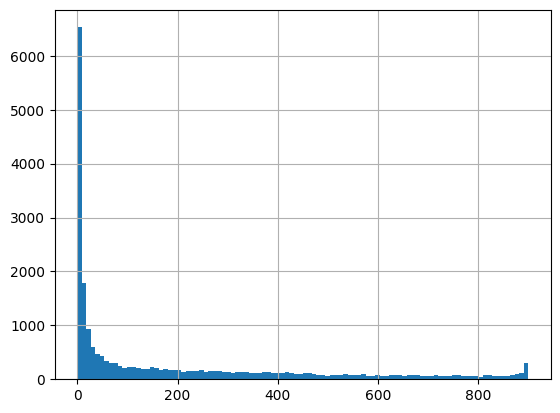

In [176]:
# sum of expression level per gene
cols = (df_cite_input > 0).sum(axis=0)
cols.hist(bins=100)


In [177]:
proteins = np.array([t.startswith('CD') for t in str_protein_id])
print("CD proteins: ", proteins.sum(), "non-CD proteins: ", (~proteins).sum())
print(df_cite_target.columns[~proteins])
w = [not((t[2:]).isnumeric()) for t in df_cite_target.columns[proteins] ]
print(df_cite_target.columns[proteins][w])

CD proteins:  119 non-CD proteins:  21
Index(['HLA-A-B-C', 'TIGIT', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b',
       'Rat-IgG2b', 'Podoplanin', 'IgM', 'KLRG1', 'HLA-DR', 'CX3CR1',
       'integrinB7', 'TCR', 'Rat-IgG1', 'Rat-IgG2a', 'FceRIa', 'IgD',
       'TCRVa7.2', 'TCRVd2', 'LOX-1', 'HLA-E'],
      dtype='object')
Index(['CD11c', 'CD45RA', 'CD49f', 'CD45RO', 'CD62L', 'CD107a', 'CD1c',
       'CD11b', 'CD1d', 'CD11a', 'CD79b', 'CD42b', 'CD62P', 'CD49b', 'CD172a',
       'CD49a', 'CD49d', 'CD158b', 'CD158e1', 'CD85j'],
      dtype='object')


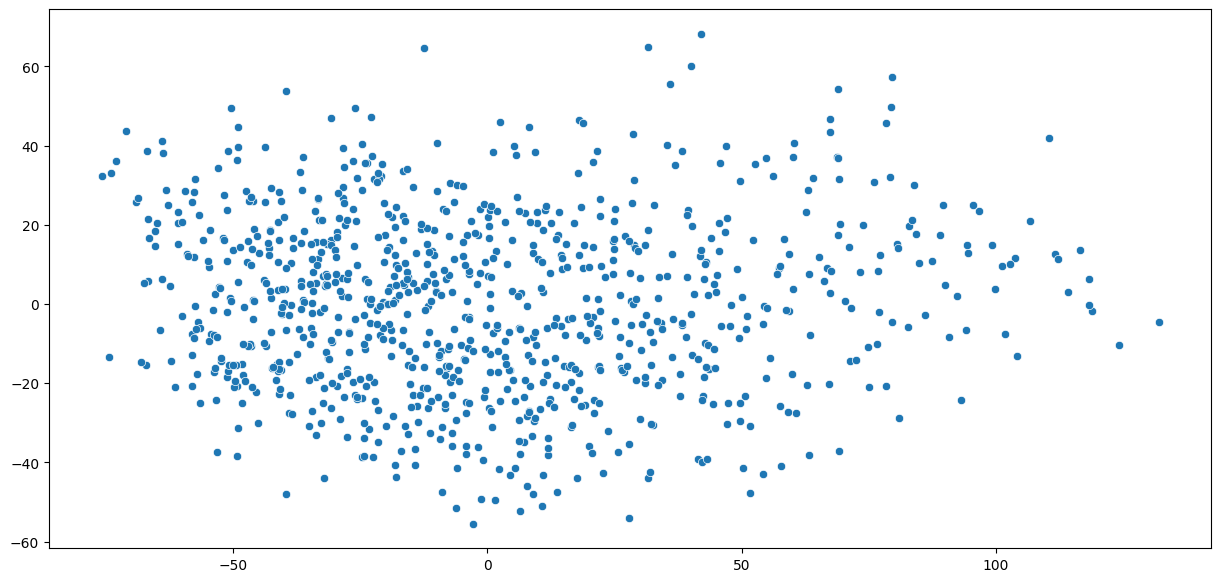

Text(0.5, 1.0, 'explained variance')

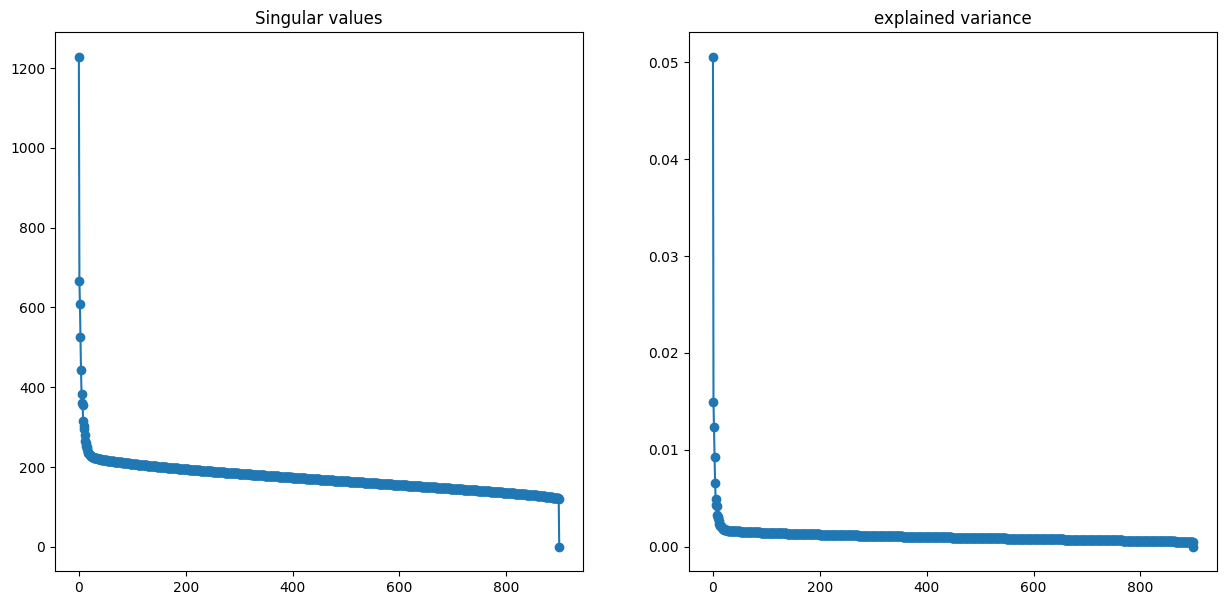

In [178]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
r = pca.fit_transform(df_cite_input)

fig = plt.figure(figsize = (15,7) )
c = 0
sns.scatterplot(x=r[:,0], y=r[:,1])# , hue = df[f]  )
plt.show()

fig = plt.figure(figsize = (15,7) )
fig.add_subplot(1, 2, 1) 
plt.plot(pca.singular_values_,'o-')
plt.title('Singular values')
fig.add_subplot(1, 2, 2) 
plt.plot(pca.explained_variance_ratio_,'o-')
plt.title('explained variance')

In [179]:
len(pca.feature_names_in_) # contains genes
r.shape # 50, 22050

(900, 900)

In [182]:
lim = 0.9
ACC_VAR = 0
for i, var in enumerate(pca.explained_variance_ratio_):
    ACC_VAR+=var
    # print(var)
    if ACC_VAR > lim: 
        print(f"{i+1} components explained {lim} of total var")
        break

732 components explained 0.9 of total var


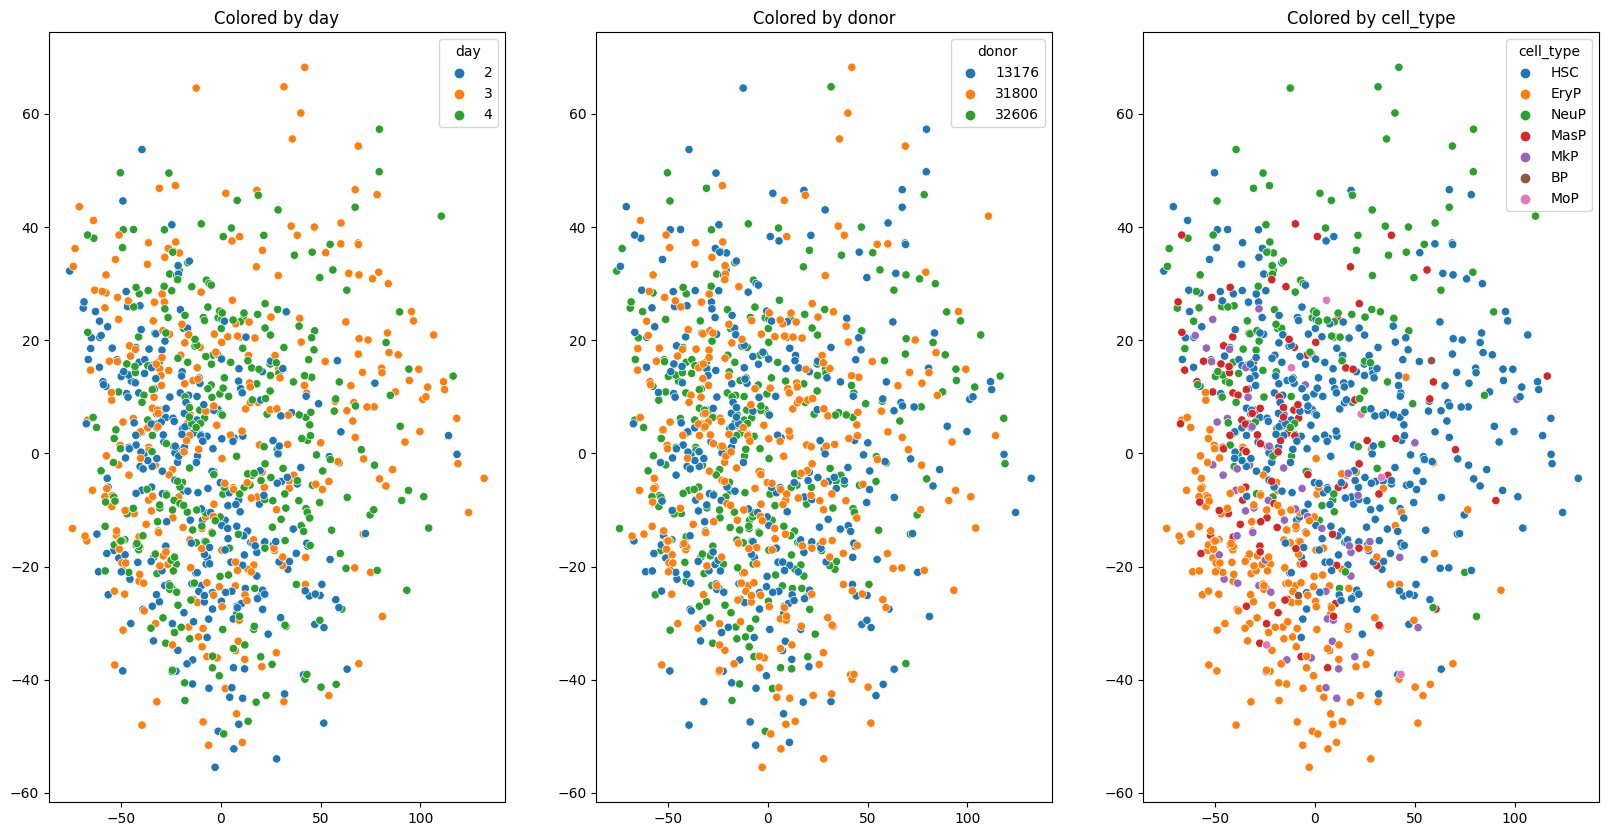

In [181]:
fig = plt.figure(figsize = (20,10) )
c = 0
for f in ['day', 'donor', 'cell_type']:# , 'technology']:
    c+=1; fig.add_subplot(1, 3 , c) 
    sns.scatterplot(x=r[:,0], y=r[:,1] , hue = df_meta_citeseq_subset[f], palette = "tab10"  )
    plt.title('Colored by '+f)
plt.show()


In [183]:
fig = plt.figure(figsize= (20,6))
dpca = {}
for i in range(5):
    v = pca.components_[i,:].ravel()
    t = np.percentile(np.abs(v),90)
    IX = np.where( np.abs(v) > t)[0]
    print(len(IX))
    l = np.array(str_gene_id)[IX]
    print(l[1:10],'and more ... Top columns contributing to  PCA'+str(i) )
    dpca[i] = l
    if i == 0:
        s = set(dpca[0])
    else:
        s = s & set(dpca[i])
        #print(s, 'Intersection',i)        
plt.show()
    
print()
s = set(dpca[0])
for i in dpca:
    s = s & set(dpca[i])
    print(len(s), 'Intersection',i)

2205
['ENSG00000149313_AASDHPPT' 'ENSG00000275700_AATF' 'ENSG00000125257_ABCC4'
 'ENSG00000117528_ABCD3' 'ENSG00000164163_ABCE1' 'ENSG00000204574_ABCF1'
 'ENSG00000033050_ABCF2' 'ENSG00000140526_ABHD2'
 'ENSG00000170846_AC093323.1'] and more ... Top columns contributing to  PCA0
2205
['ENSG00000107331_ABCA2' 'ENSG00000154265_ABCA5' 'ENSG00000131269_ABCB7'
 'ENSG00000125257_ABCC4' 'ENSG00000204574_ABCF1' 'ENSG00000106077_ABHD11'
 'ENSG00000107362_ABHD17B' 'ENSG00000164074_ABHD18'
 'ENSG00000011198_ABHD5'] and more ... Top columns contributing to  PCA1
2205
['ENSG00000115977_AAK1' 'ENSG00000127837_AAMP' 'ENSG00000107331_ABCA2'
 'ENSG00000135776_ABCB10' 'ENSG00000125257_ABCC4' 'ENSG00000114770_ABCC5'
 'ENSG00000164163_ABCE1' 'ENSG00000140526_ABHD2' 'ENSG00000011198_ABHD5'] and more ... Top columns contributing to  PCA2
2205
['ENSG00000087884_AAMDC' 'ENSG00000085563_ABCB1' 'ENSG00000103222_ABCC1'
 'ENSG00000125257_ABCC4' 'ENSG00000114779_ABHD14B' 'ENSG00000138443_ABI2'
 'ENSG00000099204_AB

<Figure size 2000x600 with 0 Axes>


2205 Intersection 0
692 Intersection 1
308 Intersection 2
94 Intersection 3
40 Intersection 4


<AxesSubplot: >

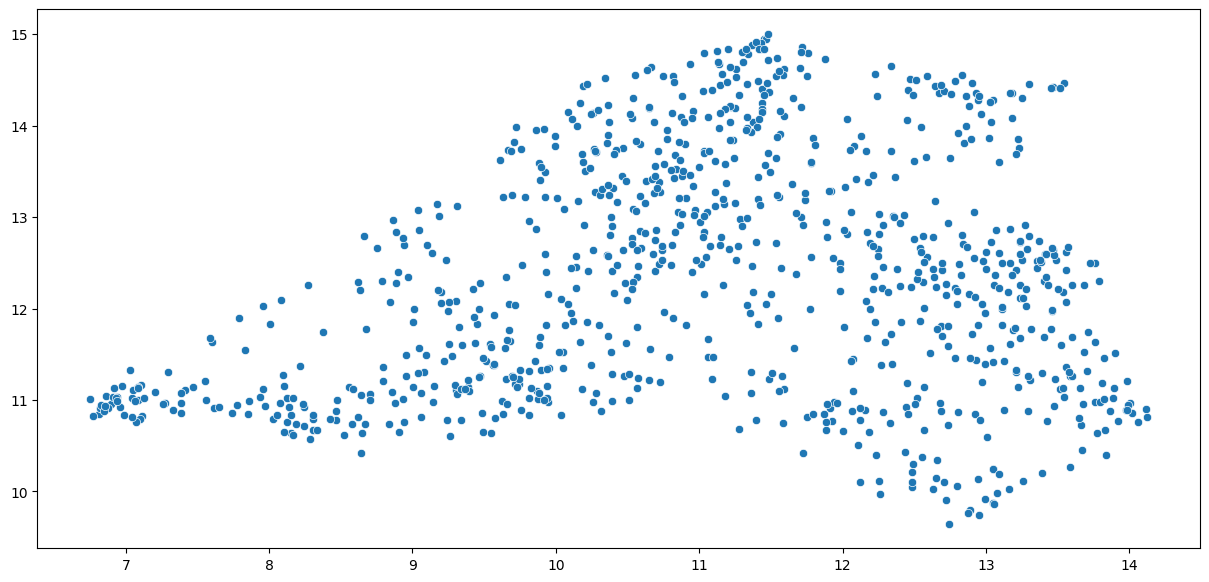

In [184]:
import umap

r = umap.UMAP().fit_transform(df_cite_input) # def neighbours = 15; components = 2

fig = plt.figure(figsize = (15,7) )
sns.scatterplot(x=r[:,0], y=r[:,1])#  , hue = df[f]  )
# plt.show()

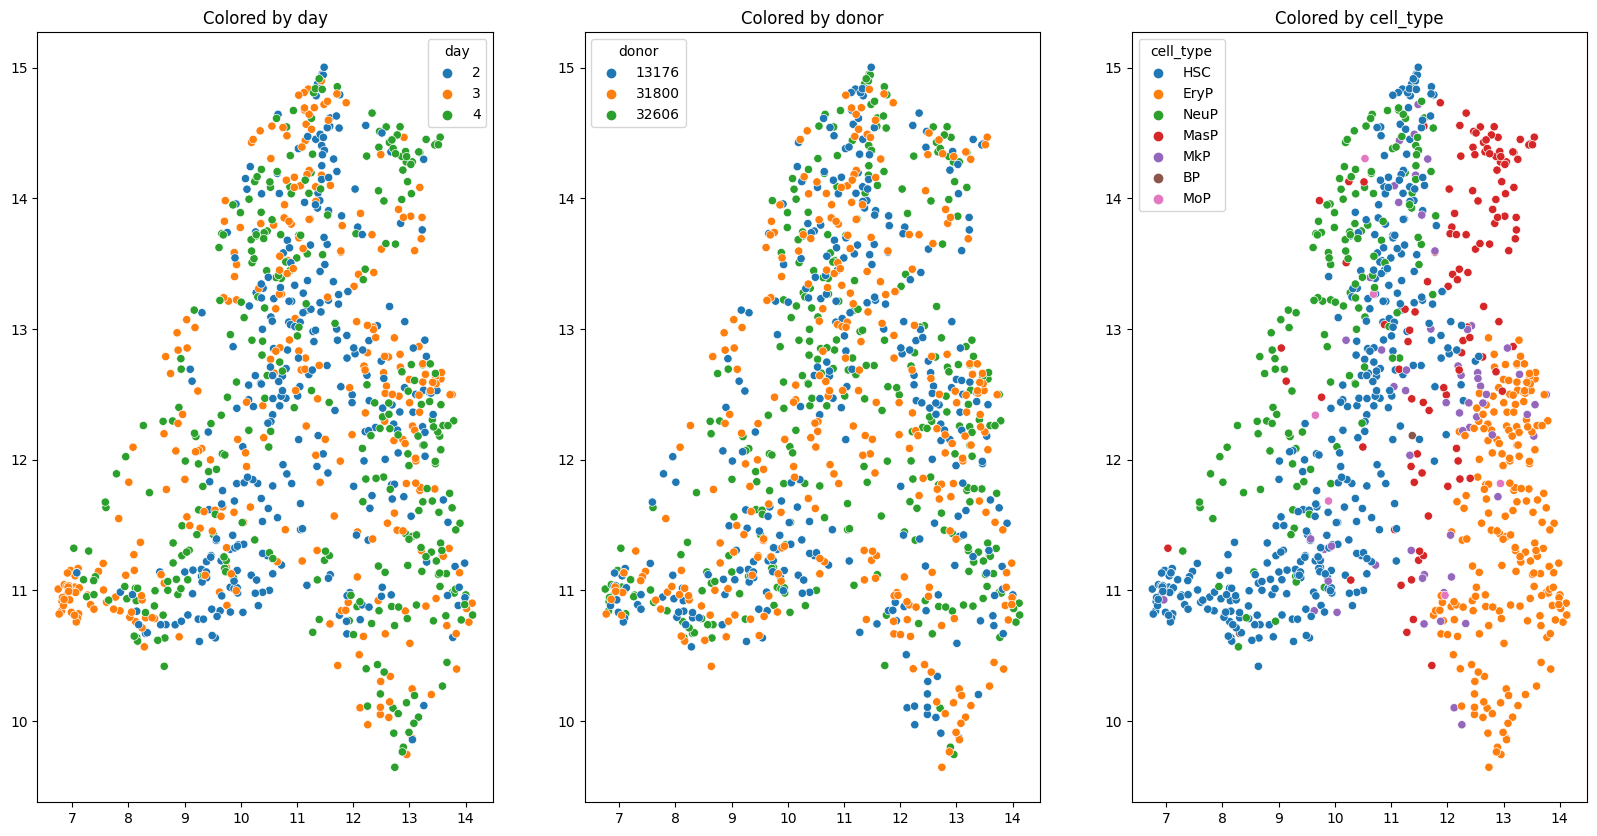

In [185]:
fig = plt.figure(figsize = (20,10) )
c = 0
for f in ['day', 'donor', 'cell_type']:
    c+=1; fig.add_subplot(1, 3 , c) 
    sns.scatterplot(x=r[:,0], y=r[:,1] , hue = df_meta_citeseq_subset[f], palette = 'tab10' )
    plt.title('Colored by '+f)
plt.show()


In [186]:
r.shape # 450,2 : representing samples using 2 values

(900, 2)

In [ ]:
K = 30

numerical_trustworthiness = validation.trustworthiness_vector(source=clf.numerical_umap_._raw_data
                                  ,embedding=clf.numerical_umap_.embedding_
                                  ,max_k=K)

categorical_trustworthiness = validation.trustworthiness_vector(source=clf.categorical_umap_._raw_data
                                  ,embedding=clf.categorical_umap_.embedding_
                                  ,max_k=K)


_=plt.plot(numerical_trustworthiness)
_=plt.plot(categorical_trustworthiness)
_=plt.ylabel("Value of K")
_= plt.xlabel(f"Trustworthiness score")
_=plt.title(f"Trustworthiness at {K}")
_=plt.legend(["numerical T", "categorical T"], loc="upper right")

## truncated SVD + PCA

from dengkw, Models using the Truncated SVD to reduce the dimension with PCA - was ran with KRR - kernel ridge

In [58]:
# doing pca on input data
from sklearn.decomposition import TruncatedSVD

svd1 = TruncatedSVD()
pca1 = svd1.fit_transform(df_cite_input)

print(pca1.shape)
pca1

(450, 2)


array([[ 2.93402244e+02, -2.06150046e+01],
       [ 2.87708142e+02, -2.24561405e+01],
       [ 2.51428142e+02,  3.35059548e+01],
       [ 2.36953194e+02,  3.65705366e+01],
       [ 2.72668221e+02, -8.48509972e+00],
       [ 2.44651012e+02,  3.65482895e+01],
       [ 2.78450620e+02,  1.58375945e-01],
       [ 2.92396617e+02, -3.22511866e+01],
       [ 2.93362554e+02, -3.45129983e+01],
       [ 3.05655518e+02, -4.73322624e+01],
       [ 2.23347779e+02,  4.32469969e+01],
       [ 2.13249119e+02,  5.31451371e+01],
       [ 2.92879852e+02, -1.28137578e+01],
       [ 2.95985870e+02, -1.29714235e+01],
       [ 2.54639012e+02,  1.48318754e+01],
       [ 2.79254340e+02, -5.23306065e+00],
       [ 2.75381114e+02,  4.65317069e-02],
       [ 2.93197797e+02, -1.98913303e+01],
       [ 2.48672175e+02,  4.13063038e+01],
       [ 2.65943620e+02,  1.37473748e+01],
       [ 2.87485233e+02, -1.33182590e+01],
       [ 2.92414743e+02, -2.05030774e+01],
       [ 2.76046491e+02, -4.26443561e+00],
       [ 2.

Text(0.5, 1.0, 'explained variance')

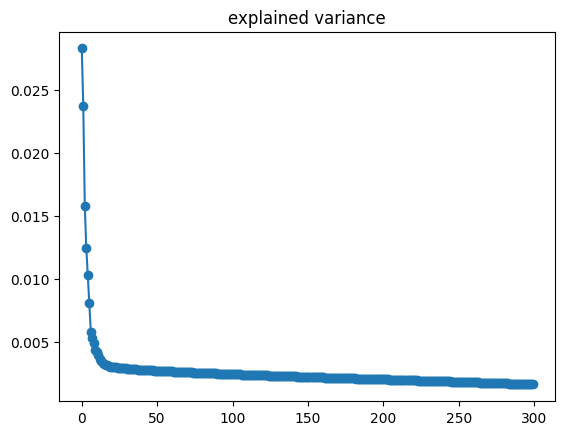

In [54]:
plt.plot(svd1.explained_variance_ratio_,'o-')
plt.title('explained variance')

In [69]:

ACC_VAR = 0
for i, var in enumerate(svd1.explained_variance_ratio_):
    ACC_VAR+=var
    # print(var)
    if ACC_VAR > .04: 
        print(f"{i+1} components explained 0.9 of total var")
        break

2 components explained 0.9 of total var


In [ ]:
# nromalisation, not really -> standardisation
train_sd = np.std(pca1, axis=1).reshape(-1,1)
train_sd[train_sd == 0] = 1
train_norm = (pca1 - np.mean(pca1, axis=1).reshape(-1, 1)) / train_sd

print(train_norm.shape)
train_norm

[[18.61214 ]
 [18.457918]
 [16.82743 ]
 [16.856127]
 [18.185135]
 [16.928684]
 [17.892065]
 [18.480778]
 [18.696262]
 [19.248589]]
(450, 300)


array([[ 1.5748729e+01, -1.1229136e+00,  1.8470219e-01, ...,
         7.9392636e-01,  5.4997306e-02, -6.5377992e-01],
       [ 1.5532993e+01, -1.2708297e+00, -1.8146900e+00, ...,
        -5.9155029e-01, -1.1649454e-01,  8.4253293e-01],
       [ 1.4931954e+01,  1.9814874e+00, -8.8793087e-01, ...,
         4.1511816e-01,  2.2961244e-01,  6.3194344e-03],
       ...,
       [ 1.5272189e+01, -1.2101411e+00,  6.7530268e-01, ...,
         1.1829206e+00,  5.5012065e-01, -1.4981967e-01],
       [ 1.3897835e+01,  1.4954754e+00,  1.0802013e+00, ...,
        -1.2337588e-01, -5.6189388e-01, -3.3728859e-01],
       [ 1.5034127e+01, -7.1243203e-01, -2.0605619e+00, ...,
        -9.7834051e-01,  1.9646924e-02,  2.2380063e-01]], dtype=float32)

In [ ]:
train_norm[1,:].shape

(300,)

In [ ]:
row = []
for i in range(300):
    x = "PCA"+ str(i)
    row.append(x)

results = pd.DataFrame(train_norm, columns = [row], index = df_meta_citeseq_subset['cell_id'])
# esults.to_csv("reduced/train_cite_reduced.csv", index=False)